## MT3DMS Problem 9

The purpose of this script is to (1) recreate the example problems that were first
described in the 1999 MT3DMS report, and (2) compare MF6-GWT solutions to the
established MT3DMS solutions.

Ten example problems appear in the 1999 MT3DMS manual, starting on page 130.
This notebook demonstrates example 9 from the list below:

  1. One-Dimensional Transport in a Uniform Flow Field
  2. One-Dimensional Transport with Nonlinear or Nonequilibrium Sorption
  3. Two-Dimensional Transport in a Uniform Flow Field
  4. Two-Dimensional Transport in a Diagonal Flow Field
  5. Two-Dimensional Transport in a Radial Flow Field
  6. Concentration at an Injection/Extraction Well
  7. Three-Dimensional Transport in a Uniform Flow Field
  8. Two-Dimensional, Vertical Transport in a Heterogeneous Aquifer
  9. _Two-Dimensional Application Example_
  10. Three-Dimensional Field Case Study

### Initial setup

Import dependencies, define the example name and workspace, and read settings from environment variables.

In [1]:
import os
import pathlib as pl
from pprint import pformat

import flopy
import git
import matplotlib.pyplot as plt
import numpy as np
from flopy.plot.styles import styles
from modflow_devtools.misc import get_env, timed

# Example name and workspace paths. If this example is running
# in the git repository, use the folder structure described in
# the README. Otherwise just use the current working directory.
example_name = "ex-gwt-mt3dms-p09"
try:
    root = pl.Path(git.Repo(".", search_parent_directories=True).working_dir)
except:
    root = None
workspace = root / "examples" if root else pl.Path.cwd()
figs_path = root / "figures" if root else pl.Path.cwd()
data_path = pl.Path(f"../data/{example_name}")
data_path = data_path if data_path.is_dir() else pl.Path.cwd()

# Settings from environment variables
write = get_env("WRITE", True)
run = get_env("RUN", True)
plot = get_env("PLOT", True)
plot_show = get_env("PLOT_SHOW", True)
plot_save = get_env("PLOT_SAVE", True)

### Define parameters

Define model units, parameters and other settings.

In [2]:
# Model units
length_units = "meters"
time_units = "seconds"

# Model parameters
nlay = 1  # Number of layers
nrow = 18  # Number of rows
ncol = 14  # Number of columns
delr = 100.0  # Column width ($m$)
delc = 100.0  # Row width ($m$)
delz = 10.0  # Layer thickness ($m$)
top = 0.0  # Top of the model ($m$)
prsity = 0.3  # Porosity
k1 = 1.474e-4  # Horiz. hyd. conductivity of fine grain material ($m/sec$)
k2 = 1.474e-7  # Horiz. hyd. conductivity of medium grain material ($m/sec$)
inj = 0.001  # Injection well rate ($m^3/sec$)
ext = -0.0189  # Extraction well pumping rate ($m^3/sec$)
al = 20.0  # Longitudinal dispersivity ($m$)
trpt = 0.2  # Ratio of horiz. transverse to longitudinal dispersivity ($m$)
perlen = 2.0  # Simulation time ($years$)

# Additional model input
hk = k1 * np.ones((nlay, nrow, ncol), dtype=float)
hk[:, 5:8, 1:8] = k2
laytyp = icelltype = 0

# Active model domain
ibound = np.ones((nlay, nrow, ncol), dtype=int)
ibound[0, 0, :] = -1
ibound[0, -1, :] = -1
idomain = np.ones((nlay, nrow, ncol), dtype=int)
icbund = 1

# Boundary conditions
# MF2K5 pumping info
qwell1 = 0.001
qwell2 = -0.0189
welspd = {0: [[0, 3, 6, qwell1], [0, 10, 6, qwell2]]}  # Well pumping info for MF2K5
cwell1 = 57.87
cwell0 = 0.0
spd = {
    0: [[0, 3, 6, cwell1, 2], [0, 10, 6, cwell0, 2]],
    1: [[0, 3, 6, cwell0, 2], [0, 10, 6, cwell0, 2]],
}  # Well info 4 MT3D
# MF6 pumping information
wellist_sp1 = []
#                   (k,  i, j),   flow,  conc
wellist_sp1.append([(0, 3, 6), qwell1, cwell1])  # Injection well
wellist_sp1.append([(0, 10, 6), qwell2, cwell0])  # Pumping well
#
wellist_sp2 = []
#                   (k,  i, j),   flow,  conc
wellist_sp2.append([(0, 3, 6), qwell1, cwell0])  # Injection well
wellist_sp2.append([(0, 10, 6), qwell2, cwell0])  # Pumping well
spd_mf6 = {0: wellist_sp1, 1: wellist_sp2}

# Transport related
sconc = 0.0
ath1 = al * trpt
dmcoef = 0.0  # m^2/s
# Time variables
perlen = [365.0 * 86400, 365.0 * 86400]
steady = [False, False]
nper = len(perlen)
nstp = [365, 365]
tsmult = [1.0, 1.0]
#
sconc = 0.0
c0 = 0.0
botm = [top - delz]
mixelm = -1

# Solver settings
nouter, ninner = 100, 300
hclose, rclose, relax = 1e-6, 1e-6, 1.0
percel = 1.0  # HMOC parameters
itrack = 2
wd = 0.5
dceps = 1.0e-5
nplane = 0
npl = 0
nph = 16
npmin = 2
npmax = 32
dchmoc = 1.0e-3
nlsink = nplane
npsink = nph
nadvfd = 1

### Model setup

Define functions to build models, write input files, and run the simulation.

In [3]:
def build_models(sim_name, mixelm=0, silent=False):
    print(f"Building mf2005 model...{sim_name}")
    mt3d_ws = os.path.join(workspace, sim_name, "mt3d")
    modelname_mf = "p09-mf"

    # Instantiate the MODFLOW model
    mf = flopy.modflow.Modflow(
        modelname=modelname_mf, model_ws=mt3d_ws, exe_name="mf2005"
    )

    # Instantiate discretization package
    # units: itmuni=4 (days), lenuni=2 (m)
    flopy.modflow.ModflowDis(
        mf,
        nlay=nlay,
        nrow=nrow,
        ncol=ncol,
        delr=delr,
        delc=delc,
        top=top,
        botm=botm,
        nper=nper,
        perlen=perlen,
        itmuni=1,
        lenuni=2,
        steady=steady,
    )

    # Instantiate basic package
    strt = np.zeros((nlay, nrow, ncol), dtype=float)
    strt[0, 0, :] = 250.0
    xc = mf.modelgrid.xcellcenters
    for j in range(ncol):
        strt[0, -1, j] = 20.0 + (xc[-1, j] - xc[-1, 0]) * 2.5 / 100
    flopy.modflow.ModflowBas(mf, ibound=ibound, strt=strt)

    # Instantiate layer property flow package
    flopy.modflow.ModflowLpf(mf, hk=hk, laytyp=laytyp)

    # Instantiate well package
    flopy.modflow.ModflowWel(mf, stress_period_data=welspd)

    # Instantiate solver package
    flopy.modflow.ModflowPcg(mf)

    # Instantiate link mass transport package (for writing linker file)
    flopy.modflow.ModflowLmt(mf)

    # Transport
    print(f"Building mt3d-usgs model...{sim_name}")

    modelname_mt = "p09-mt"
    mt = flopy.mt3d.Mt3dms(
        modelname=modelname_mt,
        model_ws=mt3d_ws,
        exe_name="mt3dusgs",
        modflowmodel=mf,
    )

    # Instantiate basic transport package
    flopy.mt3d.Mt3dBtn(
        mt,
        icbund=icbund,
        prsity=prsity,
        sconc=sconc,
        mxstrn=86400,
        nper=nper,
        perlen=perlen,
        timprs=[perlen[0], 2 * perlen[1]],
        dt0=0,
    )

    # Instatiate the advection package
    flopy.mt3d.Mt3dAdv(
        mt,
        mixelm=mixelm,
        dceps=dceps,
        nplane=nplane,
        npl=npl,
        nph=nph,
        npmin=npmin,
        npmax=npmax,
        nlsink=nlsink,
        npsink=npsink,
        percel=percel,
    )

    # Instantiate the dispersion package
    flopy.mt3d.Mt3dDsp(mt, al=al, trpt=trpt, dmcoef=dmcoef)

    # Instantiate the source/sink mixing package
    flopy.mt3d.Mt3dSsm(mt, stress_period_data=spd)

    # Instantiate the GCG solver in MT3DMS
    flopy.mt3d.Mt3dGcg(mt)

    # MODFLOW 6
    print(f"Building mf6gwt model...{sim_name}")

    name = "p09-mf6"
    gwfname = "gwf-" + name
    sim_ws = os.path.join(workspace, sim_name)
    sim = flopy.mf6.MFSimulation(sim_name=sim_name, sim_ws=sim_ws, exe_name="mf6")

    # Instantiating MODFLOW 6 time discretization
    tdis_rc = []
    for i in range(nper):
        tdis_rc.append((perlen[i], nstp[i], tsmult[i]))
    flopy.mf6.ModflowTdis(sim, nper=nper, perioddata=tdis_rc, time_units=time_units)

    # Instantiating MODFLOW 6 groundwater flow model
    gwf = flopy.mf6.ModflowGwf(
        sim,
        modelname=gwfname,
        save_flows=True,
        model_nam_file=f"{gwfname}.nam",
    )

    # Instantiating MODFLOW 6 solver for flow model
    imsgwf = flopy.mf6.ModflowIms(
        sim,
        print_option="SUMMARY",
        outer_dvclose=hclose,
        outer_maximum=nouter,
        under_relaxation="NONE",
        inner_maximum=ninner,
        inner_dvclose=hclose,
        rcloserecord=rclose,
        linear_acceleration="CG",
        scaling_method="NONE",
        reordering_method="NONE",
        relaxation_factor=relax,
        filename=f"{gwfname}.ims",
    )
    sim.register_ims_package(imsgwf, [gwf.name])

    # Instantiating MODFLOW 6 discretization package
    flopy.mf6.ModflowGwfdis(
        gwf,
        length_units=length_units,
        nlay=nlay,
        nrow=nrow,
        ncol=ncol,
        delr=delr,
        delc=delc,
        top=top,
        botm=botm,
        idomain=idomain,
        filename=f"{gwfname}.dis",
    )

    # Instantiating MODFLOW 6 initial conditions package for flow model
    strt = np.zeros((nlay, nrow, ncol), dtype=float)
    strt[0, 0, :] = 250.0
    xc = mf.modelgrid.xcellcenters
    for j in range(ncol):
        strt[0, -1, j] = 20.0 + (xc[-1, j] - xc[-1, 0]) * 2.5 / 100
    flopy.mf6.ModflowGwfic(gwf, strt=strt, filename=f"{gwfname}.ic")

    # Instantiating MODFLOW 6 node-property flow package
    flopy.mf6.ModflowGwfnpf(
        gwf,
        save_flows=False,
        icelltype=icelltype,
        k=hk,
        k33=hk,
        save_specific_discharge=True,
        filename=f"{gwfname}.npf",
    )

    # Instantiate storage package
    sto = flopy.mf6.ModflowGwfsto(gwf, ss=1.0e-05)

    # Instantiating MODFLOW 6 constant head package
    # MF6 constant head boundaries:
    chdspd = []
    # Loop through the top & bottom sides.
    for j in np.arange(ncol):
        #               l,  r, c,  head, conc
        chdspd.append([(0, 0, j), 250.0, 0.0])  # Top boundary
        hd = 20.0 + (xc[-1, j] - xc[-1, 0]) * 2.5 / 100
        chdspd.append([(0, 17, j), hd, 0.0])  # Bottom boundary
    chdspd = {0: chdspd}

    flopy.mf6.ModflowGwfchd(
        gwf,
        maxbound=len(chdspd),
        stress_period_data=chdspd,
        save_flows=False,
        auxiliary="CONCENTRATION",
        pname="CHD-1",
        filename=f"{gwfname}.chd",
    )

    # Instantiate the wel package
    flopy.mf6.ModflowGwfwel(
        gwf,
        print_input=True,
        print_flows=True,
        stress_period_data=spd_mf6,
        save_flows=False,
        auxiliary="CONCENTRATION",
        pname="WEL-1",
        filename=f"{gwfname}.wel",
    )

    # Instantiating MODFLOW 6 output control package for flow model
    flopy.mf6.ModflowGwfoc(
        gwf,
        head_filerecord=f"{gwfname}.hds",
        budget_filerecord=f"{gwfname}.bud",
        headprintrecord=[("COLUMNS", 10, "WIDTH", 15, "DIGITS", 6, "GENERAL")],
        saverecord=[("HEAD", "LAST"), ("BUDGET", "LAST")],
        printrecord=[("HEAD", "LAST"), ("BUDGET", "LAST")],
    )

    # Instantiating MODFLOW 6 groundwater transport package
    gwtname = "gwt-" + name
    gwt = flopy.mf6.MFModel(
        sim,
        model_type="gwt6",
        modelname=gwtname,
        model_nam_file=f"{gwtname}.nam",
    )
    gwt.name_file.save_flows = True

    # create iterative model solution and register the gwt model with it
    imsgwt = flopy.mf6.ModflowIms(
        sim,
        print_option="SUMMARY",
        outer_dvclose=hclose,
        outer_maximum=nouter,
        under_relaxation="NONE",
        inner_maximum=ninner,
        inner_dvclose=hclose,
        rcloserecord=rclose,
        linear_acceleration="BICGSTAB",
        scaling_method="NONE",
        reordering_method="NONE",
        relaxation_factor=relax,
        filename=f"{gwtname}.ims",
    )
    sim.register_ims_package(imsgwt, [gwt.name])

    # Instantiating MODFLOW 6 transport discretization package
    flopy.mf6.ModflowGwtdis(
        gwt,
        nlay=nlay,
        nrow=nrow,
        ncol=ncol,
        delr=delr,
        delc=delc,
        top=top,
        botm=botm,
        idomain=idomain,
        filename=f"{gwtname}.dis",
    )

    # Instantiating MODFLOW 6 transport initial concentrations
    flopy.mf6.ModflowGwtic(gwt, strt=sconc, filename=f"{gwtname}.ic")

    # Instantiating MODFLOW 6 transport advection package
    if mixelm >= 0:
        scheme = "UPSTREAM"
    elif mixelm == -1:
        scheme = "TVD"
    else:
        raise Exception()
    flopy.mf6.ModflowGwtadv(gwt, scheme=scheme, filename=f"{gwtname}.adv")

    # Instantiating MODFLOW 6 transport dispersion package
    if al != 0:
        flopy.mf6.ModflowGwtdsp(
            gwt,
            alh=al,
            ath1=ath1,
            filename=f"{gwtname}.dsp",
        )

    # Instantiating MODFLOW 6 transport mass storage package
    flopy.mf6.ModflowGwtmst(
        gwt,
        porosity=prsity,
        first_order_decay=False,
        decay=None,
        decay_sorbed=None,
        sorption=None,
        bulk_density=None,
        distcoef=None,
        filename=f"{gwtname}.mst",
    )

    # Instantiating MODFLOW 6 transport source-sink mixing package
    sourcerecarray = [
        ("WEL-1", "AUX", "CONCENTRATION"),
        ("CHD-1", "AUX", "CONCENTRATION"),
    ]
    flopy.mf6.ModflowGwtssm(
        gwt,
        sources=sourcerecarray,
        print_flows=True,
        filename=f"{gwtname}.ssm",
    )

    # Instantiating MODFLOW 6 transport output control package
    flopy.mf6.ModflowGwtoc(
        gwt,
        budget_filerecord=f"{gwtname}.cbc",
        concentration_filerecord=f"{gwtname}.ucn",
        concentrationprintrecord=[("COLUMNS", 10, "WIDTH", 15, "DIGITS", 6, "GENERAL")],
        saverecord=[("CONCENTRATION", "LAST"), ("BUDGET", "LAST")],
        printrecord=[("CONCENTRATION", "LAST"), ("BUDGET", "LAST")],
        filename=f"{gwtname}.oc",
    )

    # Instantiating MODFLOW 6 flow-transport exchange mechanism
    flopy.mf6.ModflowGwfgwt(
        sim,
        exgtype="GWF6-GWT6",
        exgmnamea=gwfname,
        exgmnameb=gwtname,
        filename=f"{name}.gwfgwt",
    )
    return mf, mt, sim


def write_models(mf2k5, mt3d, sim, silent=True):
    mf2k5.write_input()
    mt3d.write_input()
    sim.write_simulation(silent=silent)


@timed
def run_models(mf2k5, mt3d, sim, silent=True):
    success, buff = mf2k5.run_model(silent=silent, report=True)
    assert success, pformat(buff)
    success, buff = mt3d.run_model(
        silent=silent, normal_msg="Program completed", report=True
    )
    assert success, pformat(buff)
    success, buff = sim.run_simulation(silent=silent, report=True)
    assert success, pformat(buff)

### Plotting results

Define functions to plot model results.

In [4]:
# Figure properties
figure_size = (7, 5)


def plot_results(mf2k5, mt3d, mf6, idx, ax=None):
    mt3d_out_path = mt3d.model_ws
    mf6.simulation_data.mfpath.get_sim_path()

    # Get the MT3DMS concentration output
    fname_mt3d = os.path.join(mt3d_out_path, "MT3D001.UCN")
    ucnobj_mt3d = flopy.utils.UcnFile(fname_mt3d)
    conc_mt3d = ucnobj_mt3d.get_alldata()

    # Get the MF6 concentration output
    gwt = mf6.get_model(list(mf6.model_names)[1])
    ucnobj_mf6 = gwt.output.concentration()
    conc_mf6 = ucnobj_mf6.get_alldata()

    hk = mf2k5.lpf.hk.array

    # Create figure for scenario
    with styles.USGSPlot() as fs:
        sim_name = mf6.name
        plt.rcParams["lines.dashed_pattern"] = [5.0, 5.0]

        levels = np.arange(0.2, 10, 0.4)
        stp_idx = 0  # 0-based (out of 2 possible stress periods)

        # Plot after 8 years
        axWasNone = False
        if ax is None:
            fig = plt.figure(figsize=figure_size, dpi=300, tight_layout=True)
            ax = fig.add_subplot(1, 2, 1, aspect="equal")
            axWasNone = True

        ax = fig.add_subplot(1, 2, 1, aspect="equal")
        cflood = np.ma.masked_less_equal(conc_mt3d[stp_idx], 0.2)
        mm = flopy.plot.PlotMapView(ax=ax, model=mf2k5)
        mm.plot_array(hk, masked_values=[hk[0, 0, 0]], alpha=0.2)
        mm.plot_ibound()
        mm.plot_grid(color=".5", alpha=0.2)
        cs = mm.plot_array(cflood[0], alpha=0.5, vmin=0, vmax=3)
        cs = mm.contour_array(conc_mt3d[stp_idx], colors="k", levels=levels)
        plt.clabel(cs)
        plt.xlabel("Distance Along X-Axis, in meters")
        plt.ylabel("Distance Along Y-Axis, in meters")

        title = "MT3D - End of SP " + str(stp_idx + 1)
        letter = chr(ord("@") + idx + 1)
        styles.heading(letter=letter, heading=title)

        if axWasNone:
            ax = fig.add_subplot(1, 2, 2, aspect="equal")

        cflood = np.ma.masked_less_equal(conc_mf6[stp_idx], 0.2)
        mm = flopy.plot.PlotMapView(ax=ax, model=mf2k5)
        mm.plot_array(hk, masked_values=[hk[0, 0, 0]], alpha=0.2)
        mm.plot_ibound()
        mm.plot_grid(color=".5", alpha=0.2)
        cs = mm.plot_array(cflood[0], alpha=0.5, vmin=0, vmax=3)
        cs = mm.contour_array(conc_mf6[stp_idx], colors="k", levels=levels)
        plt.clabel(cs)
        plt.xlabel("Distance Along X-Axis, in meters")
        plt.ylabel("Distance Along Y-Axis, in meters")

        title = "MODFLOW 6 - End of SP " + str(stp_idx + 1)
        letter = chr(ord("@") + idx + 2)
        styles.heading(letter=letter, heading=title)

        if plot_show:
            plt.show()
        if plot_save:
            fpth = figs_path / "{}{}".format(
                sim_name,
                ".png",
            )
            fig.savefig(fpth)

### Running the example

Define and invoke a function to run the example scenario, then plot results.

In [5]:
def scenario(idx, silent=True):
    mf2k5, mt3d, sim = build_models(example_name, mixelm=mixelm)
    if write:
        write_models(mf2k5, mt3d, sim, silent=silent)
    if run:
        run_models(mf2k5, mt3d, sim, silent=silent)
    if plot:
        plot_results(mf2k5, mt3d, sim, idx)

Compares the standard finite difference solutions between MT3D and MF6.

Building mf2005 model...ex-gwt-mt3dms-p09
Building mt3d-usgs model...ex-gwt-mt3dms-p09
Building mf6gwt model...ex-gwt-mt3dms-p09


run_models took 1944.38 ms


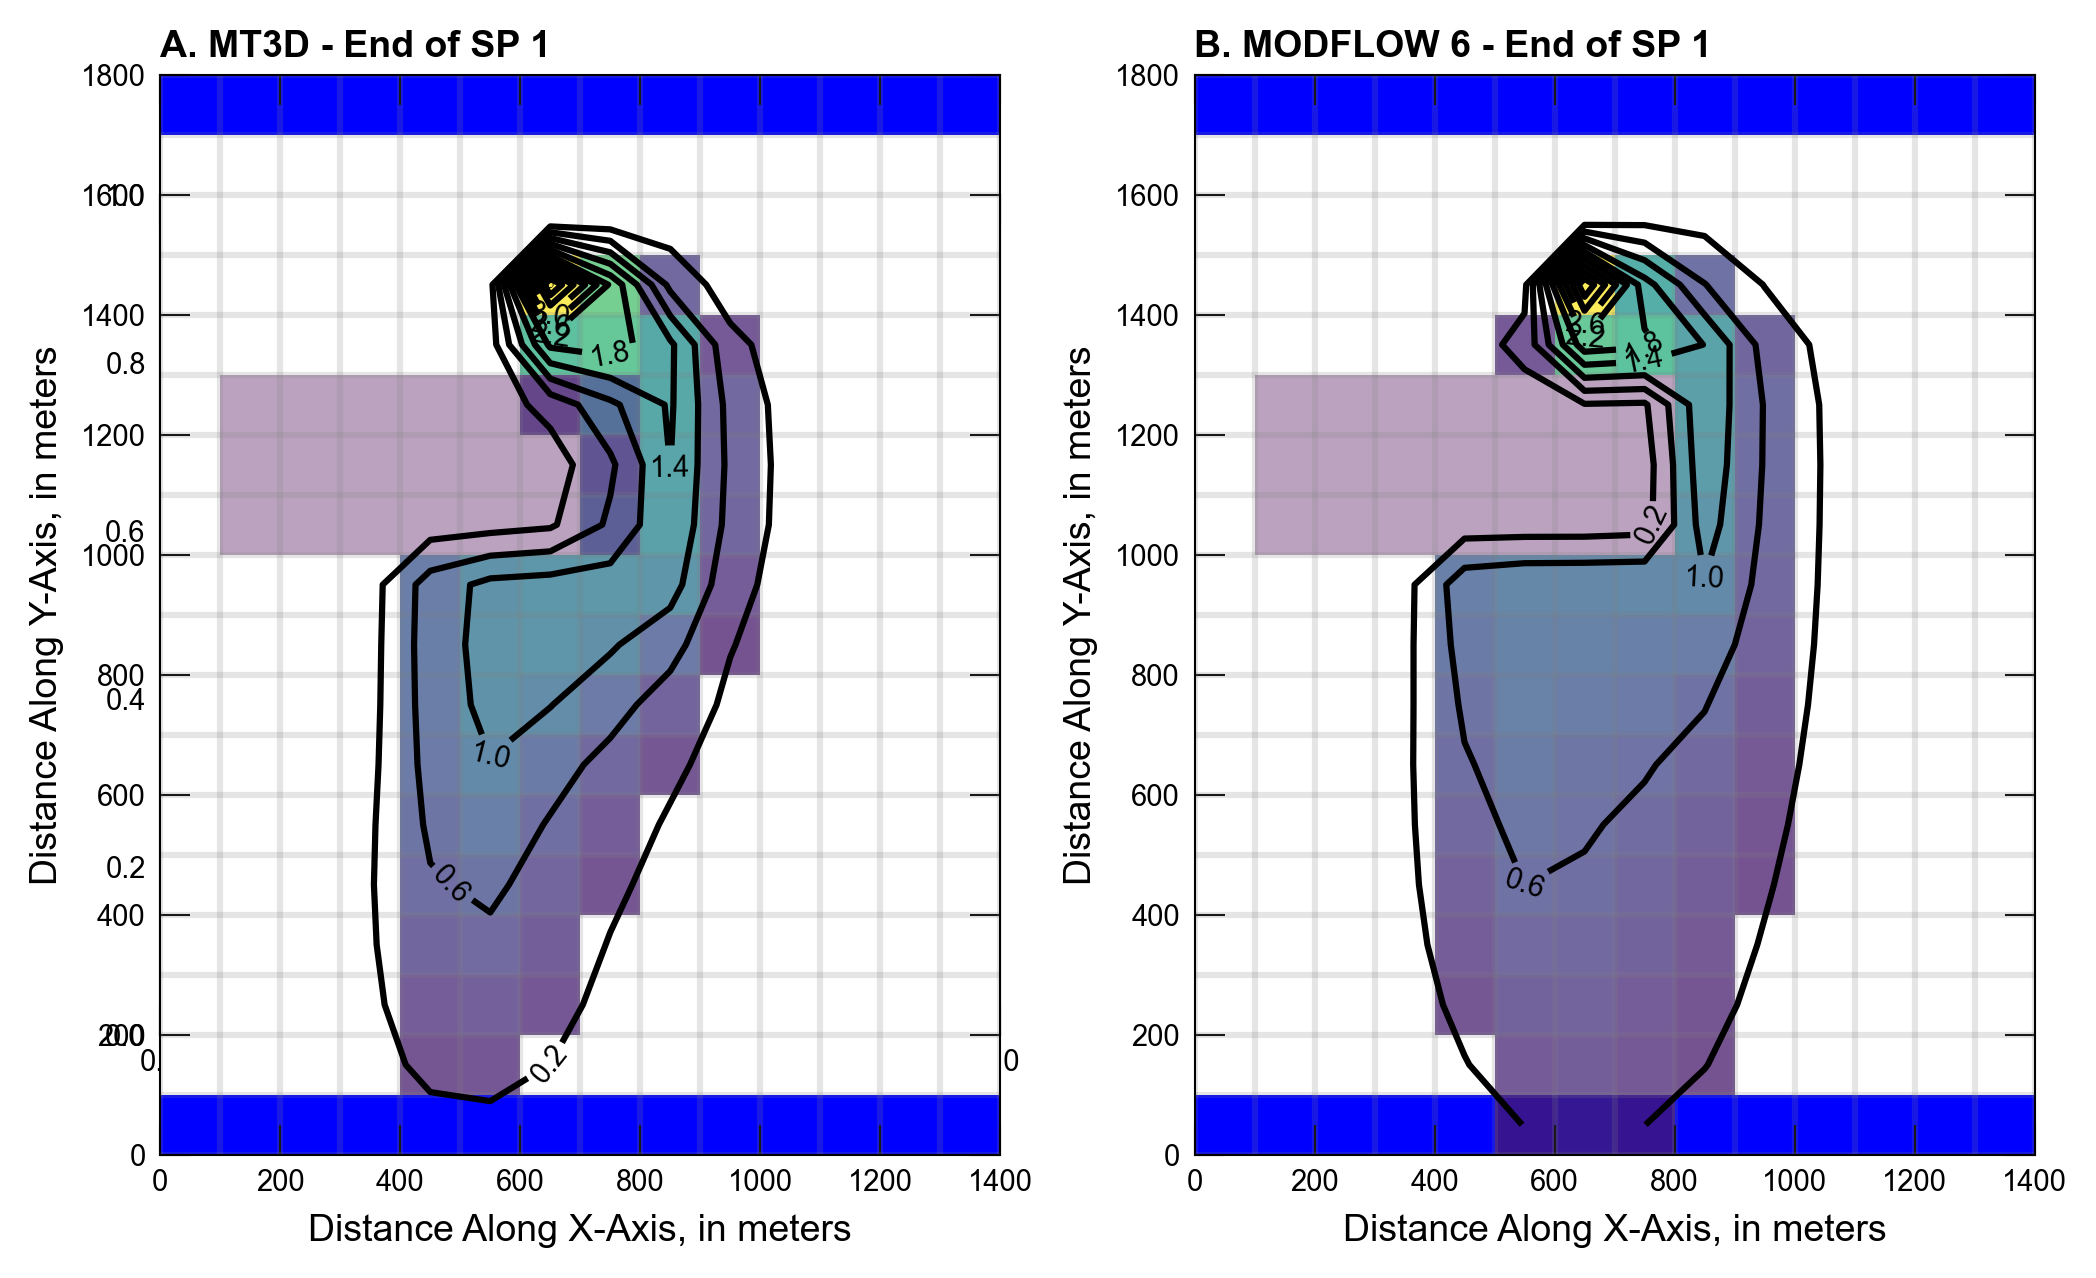

In [6]:
scenario(0, silent=True)